In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

!pip install pycm

     |████████████████████████████████| 65 kB 2.0 MB/s 
     |████████████████████████████████| 574 kB 10.2 MB/s 


In [ ]:
import time
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from pyitlib import discrete_random_variable as drv
from dtit import dtit
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
import itertools
import math
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from pycm import *

In [ ]:
def conditional_mutual_info(X,Y,Z=np.array(1)):
    
    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))
    
    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))
            
    if Z.ndim == 0: 
        c1 = np.cov(X)
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
            
        c2 = np.cov(Y)
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(X,Y)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        cmi = (1/2)*np.log((d1*d2)/d3)
    
    else:
        
        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))
        
        c1 = np.cov(np.concatenate((X, Z), axis=0))
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
    
        c2 = np.cov(np.concatenate((Y, Z), axis=0))
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(Z)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))
        
        if c4.ndim != 0: 
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()
        
        cmi = (1/2)*np.log((d1*d2)/(d3*d4))
    
    
    if math.isinf(cmi):
        cmi = 0
    
    return cmi



In [ ]:
def pca_cmi(data, theta, max_order):
    
    genes = list(data.columns)
    
    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    print("Number of edges in the initial complete graph : {}".format(num_edges))
    print()
    
    L = -1
    nochange = False
    
    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)
        
        print("Order : {}".format(L))
        print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
        print()
    
    
    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):
    
    initial_num_edges = predicted_graph.number_of_edges()
    
    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))\
        
        T = len(nhbrs)
        
        if T < L and L != 0:
            continue
        
        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))
            
            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))
                
            K = list(itertools.combinations(nhbrs, L))
                
            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)
                
                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                               
            else:  
                
                maxCmiVal = 0
                
                for zgroup in K:
                    
                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))
                    
                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)
                    
                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal
                
                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                    
                
        
    final_num_edges = predicted_graph.number_of_edges()
        
    if final_num_edges < initial_num_edges:
        return  predicted_graph, False
        
        
    return  predicted_graph, True
            

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/673:termproject/PC-CMI_Algorithm/Data/InSilicoSize10-Yeast3-trajectories.tsv', sep='\t') 
data = data.drop(['Time'], axis=1)
data

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
0,0.151815,0.843570,0.687901,0.542271,0.042484,0.628580,0.481827,0.142729,0.681395,0.635583
1,0.176599,0.878802,0.545136,0.411161,0.139176,0.686351,0.633151,0.192211,0.553457,0.732408
2,0.248199,0.852451,0.488595,0.378818,0.198915,0.713748,0.703731,0.226590,0.490167,0.740962
3,0.285180,0.704701,0.287811,0.313647,0.114908,0.869027,0.766025,0.350182,0.438760,0.733792
4,0.309298,0.768281,0.335638,0.252602,0.095511,0.830427,0.792044,0.258589,0.332607,0.795363
...,...,...,...,...,...,...,...,...,...,...
79,0.302738,0.891836,0.000000,0.799767,0.074334,0.954912,0.884307,0.456002,0.090274,0.837313
80,0.230557,0.917815,0.000000,0.698579,0.069477,0.840124,0.980214,0.473289,0.095598,0.843823
81,0.241923,0.839429,0.011325,0.813656,0.057038,0.881488,0.846068,0.508104,0.016931,0.855619
82,0.169627,0.944395,0.000000,0.735319,0.052242,0.893372,0.812333,0.431864,0.160832,0.923225


Number of edges in the initial complete graph : 45

Order : 0
Number of edges in the predicted graph : 35



Final Prediction:
-----------------
Order : 0
Number of edges in the predicted graph : 35

[[0 0 1 1 1 1 1 0 1 0]
 [0 0 1 1 1 1 0 0 1 1]
 [1 1 0 1 0 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 0 1 0 1 0 0 0 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 1 1 0 0 0 1 1 1]
 [0 0 1 1 0 1 1 0 1 1]
 [1 1 1 1 0 1 1 1 0 1]
 [0 1 1 1 1 1 1 1 1 0]]


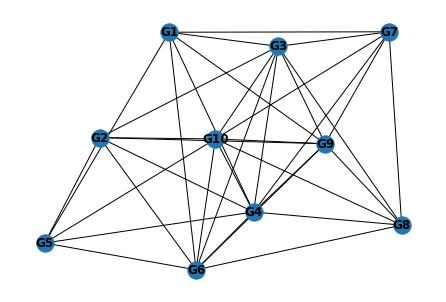

In [ ]:
predicted_graph = pca_cmi(data, 0.02, 10)
predicted_adjMatrix = nx.adjacency_matrix(predicted_graph)

print(predicted_adjMatrix.todense())

In [ ]:
benchmark_network = pd.read_csv('/content/drive/MyDrive/673:termproject/PC-CMI_Algorithm/Test/DREAM3GoldStandard_InSilicoSize10_Yeast3.txt', sep='\t', header=None)
benchmark_network = benchmark_network.loc[benchmark_network[2] == 1]
benchmark_network

,0,1,2
0,G2,G1,1
1,G3,G1,1
2,G4,G1,1
3,G5,G1,1
4,G6,G1,1
5,G3,G2,1
6,G7,G2,1
7,G7,G3,1
8,G3,G4,1
9,G2,G5,1


[[0 0 1 1 1 1 1 0 0 0]
 [0 0 0 1 0 0 0 1 0 1]
 [1 0 0 1 0 1 0 1 0 0]
 [1 1 1 0 1 1 0 1 0 0]
 [1 0 0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 1 1 1 1]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 1 1 0 1 0 0 1 1]
 [0 0 0 0 0 1 0 1 0 1]
 [0 1 0 0 0 1 0 1 1 0]]


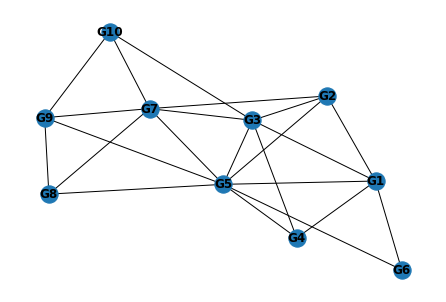

In [ ]:
import matplotlib.pyplot as plt

benchmark_graph = nx.Graph()

for i in (1,10):
    benchmark_graph.add_node('G'+str(i))

for row in range(0,benchmark_network.shape[0]):
    benchmark_graph.add_edge(benchmark_network[0][row], benchmark_network[1][row])

nx.draw(benchmark_graph, with_labels=True, font_weight='bold')

benchmark_adjMatrix = nx.adjacency_matrix(benchmark_graph)

print(benchmark_adjMatrix.todense())

In [ ]:
# editDistance = nx.optimize_graph_edit_distance(predicted_graph, benchmark_graph)
# print(list(editDistance))

In [ ]:
y_test = benchmark_adjMatrix.todense().flatten()
y_pred = predicted_adjMatrix.todense().flatten()

y_pred = np.asarray(y_pred)
y_test = np.asarray(y_test)

y_pred = y_pred.reshape(y_pred.shape[1],)
y_test = y_test.reshape(y_test.shape[1],)

In [ ]:


cm = ConfusionMatrix(y_test, y_pred)
# cm.relabel(mapping=classdict)
print(cm.ACC_Macro)

0.66


In [ ]:
y_pred

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

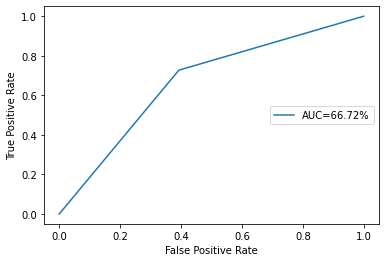

In [ ]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='AUC='+str(round(auc*100,2))+'%')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc = 5)
# show the plot
plt.show()